In [1]:
import pandas as pd

df = pd.read_csv('../../survey_processing/processed_data/dhs_processed.csv')
df

CENTROID_ID        SURVEY_NAME   COUNTRY  YEAR    LATNUM    LONGNUM  \
0      UG201600000001    Uganda_DHS_2016    Uganda  2016  0.320188  32.568206   
1      UG201600000002    Uganda_DHS_2016    Uganda  2016  0.340653  32.593627   
2      UG201600000003    Uganda_DHS_2016    Uganda  2016  0.313103  32.566556   
3      UG201600000004    Uganda_DHS_2016    Uganda  2016  0.353368  32.558144   
4      UG201600000005    Uganda_DHS_2016    Uganda  2016  0.367388  32.594357   
...               ...                ...       ...   ...       ...        ...   
24209  ET201900000301  Ethiopia_DHS_2019  Ethiopia  2019  9.614227  41.997375   
24210  ET201900000302  Ethiopia_DHS_2019  Ethiopia  2019  9.554591  41.863785   
24211  ET201900000303  Ethiopia_DHS_2019  Ethiopia  2019  9.524405  41.834015   
24212  ET201900000304  Ethiopia_DHS_2019  Ethiopia  2019  9.514266  41.770584   
24213  ET201900000305  Ethiopia_DHS_2019  Ethiopia  2019  9.521566  41.739325   

       cluster  health_vac_moddep  health_con_moddep  health_ari_moddep  ...  \
0          1.0           0.000000                0.0                0.0  ...   
1          2.0           0.032258                0.0                0.0  ...   
2          3.0           0.052632                0.0                0.0  ...   
3          4.0           0.108108                0.0                0.0  ...   
4          5.0           0.034483                0.0                0.0  ...   
...        ...                ...                ...                ...  ...   
24209    301.0           0.054054                0.0                0.0  ...   
24210    302.0           0.098361                0.0                0.0  ...   
24211    303.0           0.042553                0.0                0.0  ...   
24212    304.0           0.029126                0.0                0.0  ...   
24213    305.0           0.048544                0.0                0.0  ...   

       hv201_71     hv009     hv105     hv216      v005  hv205_14  v312_17  \
0           0.0       NaN       NaN       NaN       NaN       0.0      0.0   
1           0.0  0.148859  0.299020  0.065217  0.119688       0.0      0.0   
2           0.0  0.116183  0.058824  0.065217  0.085795       0.0      0.0   
3           0.0       NaN       NaN       NaN       NaN       0.0      0.0   
4           0.0  0.148133  0.435294  0.065217  0.146261       0.0      0.0   
...         ...       ...       ...       ...       ...       ...      ...   
24209       0.0  0.247087  0.535858  0.068791  0.005866       0.0      0.0   
24210       0.0  0.203657  0.295486  0.078868  0.008044       0.0      0.0   
24211       0.0  0.249230  0.496521  0.078541  0.009587       0.0      0.0   
24212       0.0  0.272525  0.478391  0.071872  0.005691       0.0      0.0   
24213       0.0  0.260984  0.417532  0.086957  0.006236       0.0      0.0   

       v312_2  hv201_12  hv205_31  
0         0.0       0.0  0.000000  
1         0.0       0.0  0.166667  
2         0.0       0.0  0.000000  
3         0.0       0.0  0.000000  
4         0.0       0.0  0.000000  
...       ...       ...       ...  
24209     0.0       0.0  0.986301  
24210     0.0       0.0  0.093023  
24211     0.0       0.0  0.946237  
24212     0.0       0.0  0.540816  
24213     0.0       0.0  0.225490  

[24214 rows x 159 columns]

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
# Convert the DataFrame into a GeoDataFrame
def append_geo(df):
    gdf_points = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df['LONGNUM'], df['LATNUM']),
        crs="EPSG:4326"
    )

    # Load the admin 2 boundaries GeoDataFrame
    # Ensure that the file includes polygons for admin 2 subdivisions in Africa
    admin2_gdf = gpd.read_file('afr_adm2/afr_g2014_2013_2.shp')

    # Project both GeoDataFrames to a common CRS if necessary
    if admin2_gdf.crs != gdf_points.crs:
        admin2_gdf = admin2_gdf.to_crs(gdf_points.crs)

    # Perform the spatial join
    # 'how="left"' means all points will remain, gaining admin 2 data if they fall within a polygon
    joined_gdf = gpd.sjoin(gdf_points, admin2_gdf, how="left", predicate="within")

    # Suppose the admin 2 name column in the polygons is named "admin2_name"
    return joined_gdf

/rds/project/rds-KNoCjrg2atA/cs-yang3/envs/sat/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_204579/194833196.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if y

<Axes: >

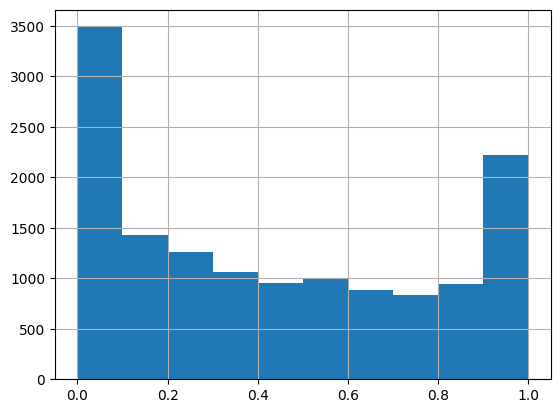

In [3]:
df['dep_sanitation_sev'].hist()

In [4]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
sub_indicators = ['dep_housing_sev',
 'dep_water_sev',
 'dep_sanitation_sev',
 'dep_health_sev',
 'dep_education_sev',
 'dep_nutrition_sev']
def get_test_df(fold, target = 'deprived_sev'):
    folder = f'../dino/results/split_spatialS_{fold}_[4, 3, 2]/'
    # Load training and test data
    X_train = pd.read_csv(folder+'X_train.csv')
    y_train = pd.read_csv(folder+'y_train.csv').squeeze()  # ensure it's a Series
    X_test = pd.read_csv(folder+'X_test.csv')
    y_test = pd.read_csv(folder+'y_test.csv').squeeze()

    test_csv = f'../../survey_processing/processed_data/test_fold_{fold}.csv'
    train_csv = f'../../survey_processing/processed_data/train_fold_{fold}.csv'
    test_df = pd.read_csv(test_csv)
    train_df = pd.read_csv(train_csv)
    import os
    available_imagery = []
    imagery_path = '/home/cs-yang3/rds/rds-t2-cs177-KNoCjrg2atA/wp3/data/satellite_imagery/esa_10'
    for d in os.listdir(imagery_path):
        if d[-2] == 'S':
            for f in os.listdir(os.path.join(imagery_path, d)):
                available_imagery.append(os.path.join(imagery_path, d, f))

    def is_available(centroid_id):
        for centroid in available_imagery:
            if centroid_id in centroid:
                return True
        return False
    test_df = test_df[test_df['CENTROID_ID'].apply(is_available)]
    train_df = train_df[train_df['CENTROID_ID'].apply(is_available)]

    test_df.dropna(subset=['deprived_sev'], inplace=True)
    train_df.dropna(subset=['deprived_sev'], inplace=True)
    
    # Define a pipeline with scaling and RidgeCV
    pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000], cv=5))
    ])
    for ind in sub_indicators:
        # Fit the pipeline on training data
        pipeline.fit(X_train, train_df[ind])

        # Predict on the test set
        y_pred = pipeline.predict(X_test).clip(0, 1)
        train_pred = pipeline.predict(X_train).clip(0, 1)

        # print indicator range
        print(ind, train_df[ind].mean())

        # Calculate MAE
        mae = mean_absolute_error(test_df[ind], y_pred)
        print(ind+" Test MAE:", mae)
        train_mae = mean_absolute_error(train_df[ind], train_pred)
        print(ind+" Train MAE:", train_mae)
        test_df[ind+'_pred'] = y_pred
        train_df[ind+'_pred'] = train_pred
    return test_df

# get all 5 fold and stack them
test_df = pd.concat([get_test_df(fold) for fold in range(1, 6)])

dep_housing_sev 0.1762466564273592
dep_housing_sev Test MAE: 0.10692317453252294
dep_housing_sev Train MAE: 0.0987030021449896
dep_water_sev 0.265446343263645
dep_water_sev Test MAE: 0.19417253267072
dep_water_sev Train MAE: 0.1766991868343991
dep_sanitation_sev 0.40453376615261544
dep_sanitation_sev Test MAE: 0.17022351063327432
dep_sanitation_sev Train MAE: 0.13470391916168198
dep_health_sev 0.01269274118152275
dep_health_sev Test MAE: 0.012758015753619444
dep_health_sev Train MAE: 0.011449218383661157
dep_education_sev 0.10798533148436824
dep_education_sev Test MAE: 0.05827963090944665
dep_education_sev Train MAE: 0.04887369580956931
dep_nutrition_sev 0.020120003271945335
dep_nutrition_sev Test MAE: 0.017109166764323266
dep_nutrition_sev Train MAE: 0.01615041453750509
dep_housing_sev 0.17582052397463663
dep_housing_sev Test MAE: 0.1075014924162754
dep_housing_sev Train MAE: 0.09538163618464063
dep_water_sev 0.2633642703981376
dep_water_sev Test MAE: 0.19809376025759115
dep_water_sev

In [5]:
# train_df['error'] = (train_df['deprived_sev'] - train_df['y_pred']).abs()
# train_df['are'] = (train_df['error'] / train_df['deprived_sev'])

In [6]:
test_df = (
    test_df.groupby('CENTROID_ID', as_index=False)  # Group by CENTROID_ID
    .agg(lambda x: x.mean() if x.dtype.kind in 'biufc' else x.iloc[0])  # Mean for numeric, first value for others
)
test_df

CENTROID_ID        SURVEY_NAME   COUNTRY    YEAR     LATNUM  \
0     AO201500000001    Angola_DHS_2015    Angola  2015.0 -12.101381   
1     AO201500000002    Angola_DHS_2015    Angola  2015.0  -9.663518   
2     AO201500000003    Angola_DHS_2015    Angola  2015.0  -8.928897   
3     AO201500000004    Angola_DHS_2015    Angola  2015.0 -14.287585   
4     AO201500000005    Angola_DHS_2015    Angola  2015.0 -14.211038   
...              ...                ...       ...     ...        ...   
8645  ZW201500000396  Zimbabwe_DHS_2015  Zimbabwe  2015.0 -17.915288   
8646  ZW201500000397  Zimbabwe_DHS_2015  Zimbabwe  2015.0 -18.379501   
8647  ZW201500000398  Zimbabwe_DHS_2015  Zimbabwe  2015.0 -16.660612   
8648  ZW201500000399  Zimbabwe_DHS_2015  Zimbabwe  2015.0 -17.914251   
8649  ZW201500000400  Zimbabwe_DHS_2015  Zimbabwe  2015.0 -17.859114   

        LONGNUM  cluster  health_vac_moddep  health_con_moddep  \
0     14.140703      1.0           0.120000           0.013333   
1     20.377014      2.0           0.087719           0.000000   
2     13.299542      3.0           0.020408           0.000000   
3     17.621653      4.0           0.129630           0.018519   
4     13.546263      5.0           0.109091           0.018182   
...         ...      ...                ...                ...   
8645  31.156115    396.0           0.024390           0.000000   
8646  31.872287    397.0           0.025641           0.000000   
8647  29.850649    398.0           0.000000           0.000000   
8648  30.956975    399.0           0.045455           0.022727   
8649  31.797626    400.0           0.000000           0.000000   

      health_ari_moddep  ...  v312_17  v312_2  hv201_12  hv205_31  \
0                   0.0  ...      0.0     0.0       0.0  1.000000   
1                   0.0  ...      0.0     0.0       0.0  0.000000   
2                   0.0  ...      0.0     0.0       0.0  0.000000   
3                   0.0  ...      0.0     0.0       0.0  0.592593   
4                   0.0  ...      0.0     0.0       0.0  1.000000   
...                 ...  ...      ...     ...       ...       ...   
8645                0.0  ...      0.0     0.0       0.0  0.000000   
8646                0.0  ...      0.0     0.0       0.0  0.250000   
8647                0.0  ...      0.0     0.0       0.0  0.431373   
8648                0.0  ...      0.0     0.0       0.0  0.000000   
8649                0.0  ...      0.0     0.0       0.0  0.035714   

      dep_housing_sev_pred  dep_water_sev_pred  dep_sanitation_sev_pred  \
0                 0.249073            0.461470                 0.758116   
1                 0.141273            0.258966                 0.111901   
2                 0.118798            0.112239                 0.051586   
3                 0.241445            0.578387                 0.274508   
4                 0.265776            0.677049                 0.798584   
...                    ...                 ...                      ...   
8645              0.126954            0.035709                 0.036799   
8646              0.030200            0.319990                 0.201798   
8647              0.258283            0.691662                 0.698451   
8648              0.104631            0.000000                 0.040728   
8649              0.064024            0.167271                 0.317813   

      dep_health_sev_pred  dep_education_sev_pred  dep_nutrition_sev_pred  
0                0.009332                0.208937                0.042866  
1                0.059255                0.179847                0.030279  
2                0.013092                0.118184                0.013644  
3                0.056911                0.254921                0.027513  
4                0.027192                0.288800                0.034580  
...                   ...                     ...                     ...  
8645             0.018815                0.063428                0.023587  
8646         

In [14]:
test_with_geo = append_geo(test_df)
grouped_df = test_with_geo

In [15]:
# aggregated by country + admin2 and average by error
grouped_df = test_with_geo.groupby(['COUNTRY', 'ADM2_NAME'])[sub_indicators+[i+'_pred' for i in sub_indicators]+['LATNUM','LONGNUM']].mean().reset_index()

In [16]:
grouped_df.head()

COUNTRY     ADM2_NAME  dep_housing_sev  dep_water_sev  dep_sanitation_sev  \
0  Angola   Alto Cauale         0.306122       0.938776            0.755102   
1  Angola  Alto Zambeze         0.389843       0.666825            0.094265   
2  Angola        Ambaca         0.095692       0.407196            0.647310   
3  Angola        Amboim         0.155381       0.511609            0.503606   
4  Angola        Ambriz         0.078999       0.275510            0.306781   

   dep_health_sev  dep_education_sev  dep_nutrition_sev  dep_housing_sev_pred  \
0        0.020408           0.265306           0.081633              0.419731   
1        0.103982           0.435585           0.048368              0.350910   
2        0.094504           0.245726           0.031018              0.241502   
3        0.056510           0.211566           0.032774              0.150633   
4        0.065010           0.127880           0.008065              0.279025   

   dep_water_sev_pred  dep_sanitation_sev_pred  dep_health_sev_pred  \
0            0.561892                 0.816005             0.058644   
1            0.565928                 0.556615             0.057604   
2            0.343378                 0.523843             0.038756   
3            0.490966                 0.353061             0.039476   
4            0.423717                 0.367320             0.052060   

   dep_education_sev_pred  dep_nutrition_sev_pred     LATNUM    LONGNUM  
0                0.248910                0.037491  -7.487095  16.225420  
1                0.254858                0.035823 -11.772236  23.197412  
2                0.161595                0.026826  -8.266549  15.527677  
3                0.148164                0.027026 -10.852732  14.415432  
4                0.150004                0.020247  -7.857252  13.418285

In [17]:
for sub in sub_indicators:
    print((grouped_df[sub] - grouped_df[sub+'_pred']).abs().mean(), sub)

0.06893405347533985 dep_housing_sev
0.1339268513192974 dep_water_sev
0.1350453526157483 dep_sanitation_sev
0.0108103487860676 dep_health_sev
0.04023757807846174 dep_education_sev
0.01030510050128755 dep_nutrition_sev


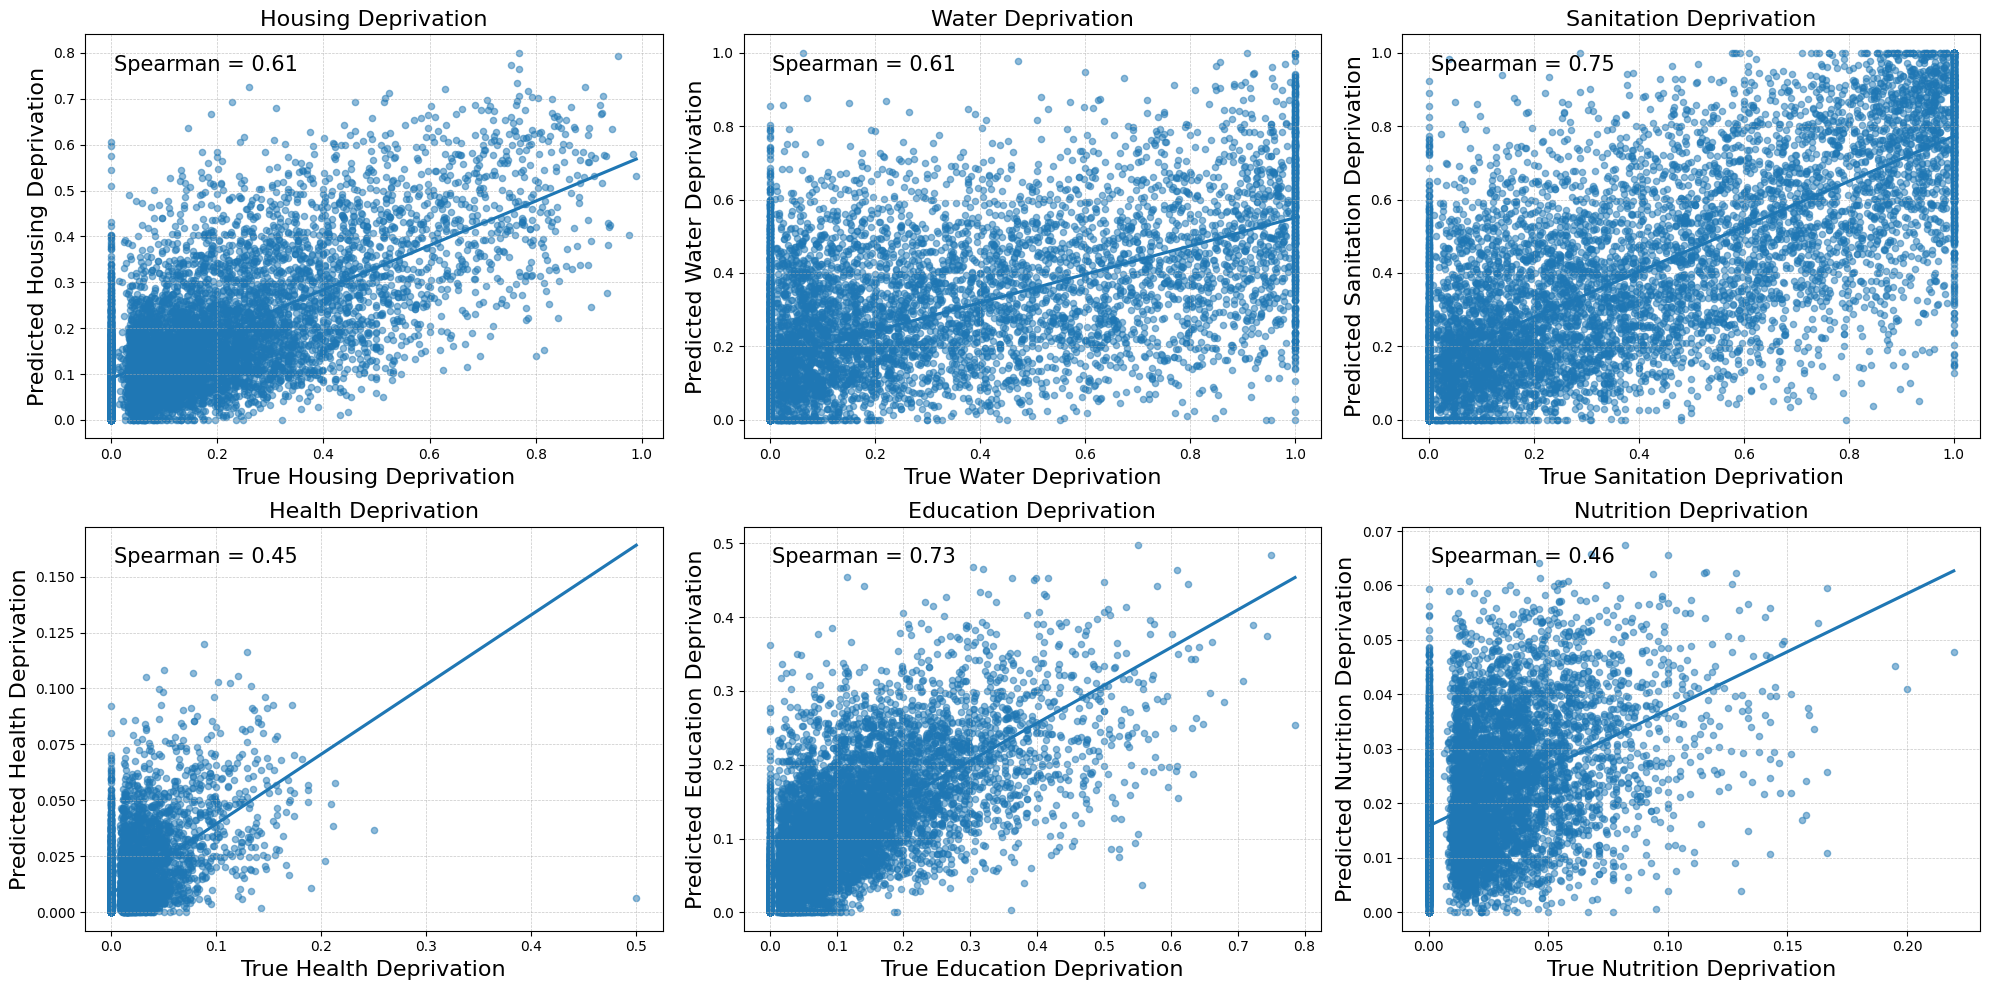

In [11]:
grouped_df = test_with_geo
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

ind_dict = {'dep_housing_sev': 'Housing Deprivation',
    'dep_water_sev': 'Water Deprivation',
    'dep_sanitation_sev': 'Sanitation Deprivation',
    'dep_health_sev': 'Health Deprivation',
    'dep_education_sev': 'Education Deprivation',
    'dep_nutrition_sev': 'Nutrition Deprivation'}

# Dictionary mapping column name to a more descriptive label
ind_dict = {
    'dep_housing_sev': 'Housing Deprivation',
    'dep_water_sev': 'Water Deprivation',
    'dep_sanitation_sev': 'Sanitation Deprivation',
    'dep_health_sev': 'Health Deprivation',
    'dep_education_sev': 'Education Deprivation',
    'dep_nutrition_sev': 'Nutrition Deprivation'
}

# Assume your DataFrame is called grouped_df
# Columns: COUNTRY, ADM2_NAME, <sub_indicators>, <sub_indicators>_pred

# Create a 3x2 grid of subplots (6 total)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array of Axes for easy iteration

for i, ind in enumerate(sub_indicators):
    ax = axes[i]
    
    # Plot scatter + regression line on the specified Axes
    sns.regplot(
        data=grouped_df,
        x=ind,
        y=f"{ind}_pred",
        ax=ax,
        scatter_kws={"alpha": 0.5, "s": 20,},
        ci=None,
    )
    
    # Compute Spearman correlation
    rho, p_value = spearmanr(grouped_df[ind], grouped_df[f"{ind}_pred"])
    
    # Annotate correlation in the top-left corner of the subplot
    ax.text(
        0.05, 0.95,
        f"Spearman = {rho:.2f}",
        transform=ax.transAxes,
        fontsize=15,
        verticalalignment="top"
    )
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    # Set axes labels and title
    ax.set_xlabel(f"True {ind_dict[ind]}", fontsize=16)
    ax.set_ylabel(f"Predicted {ind_dict[ind]}", fontsize=16)
    ax.set_title(f"{ind_dict[ind]}", fontsize=16)

# If you have fewer than 6 indicators, remove extra subplots.
# (Here we assume exactly 6. If more or fewer, adjust accordingly.)
for j in range(len(sub_indicators), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

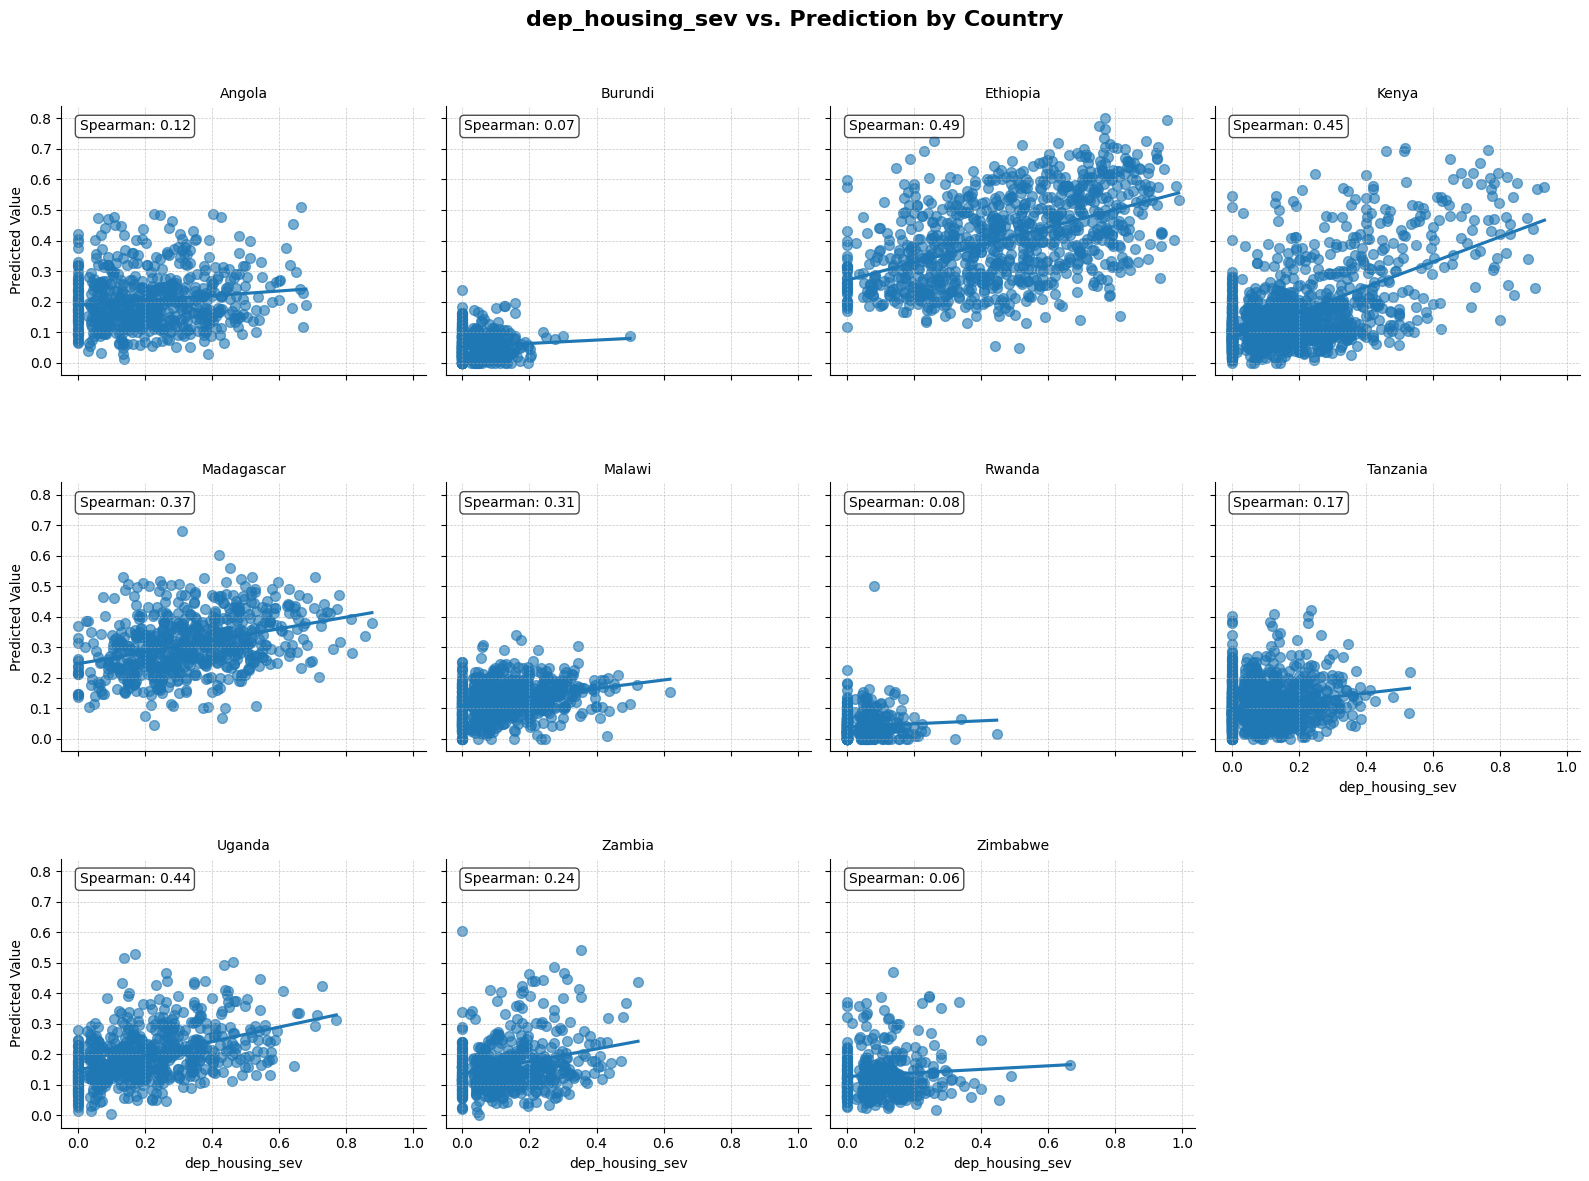

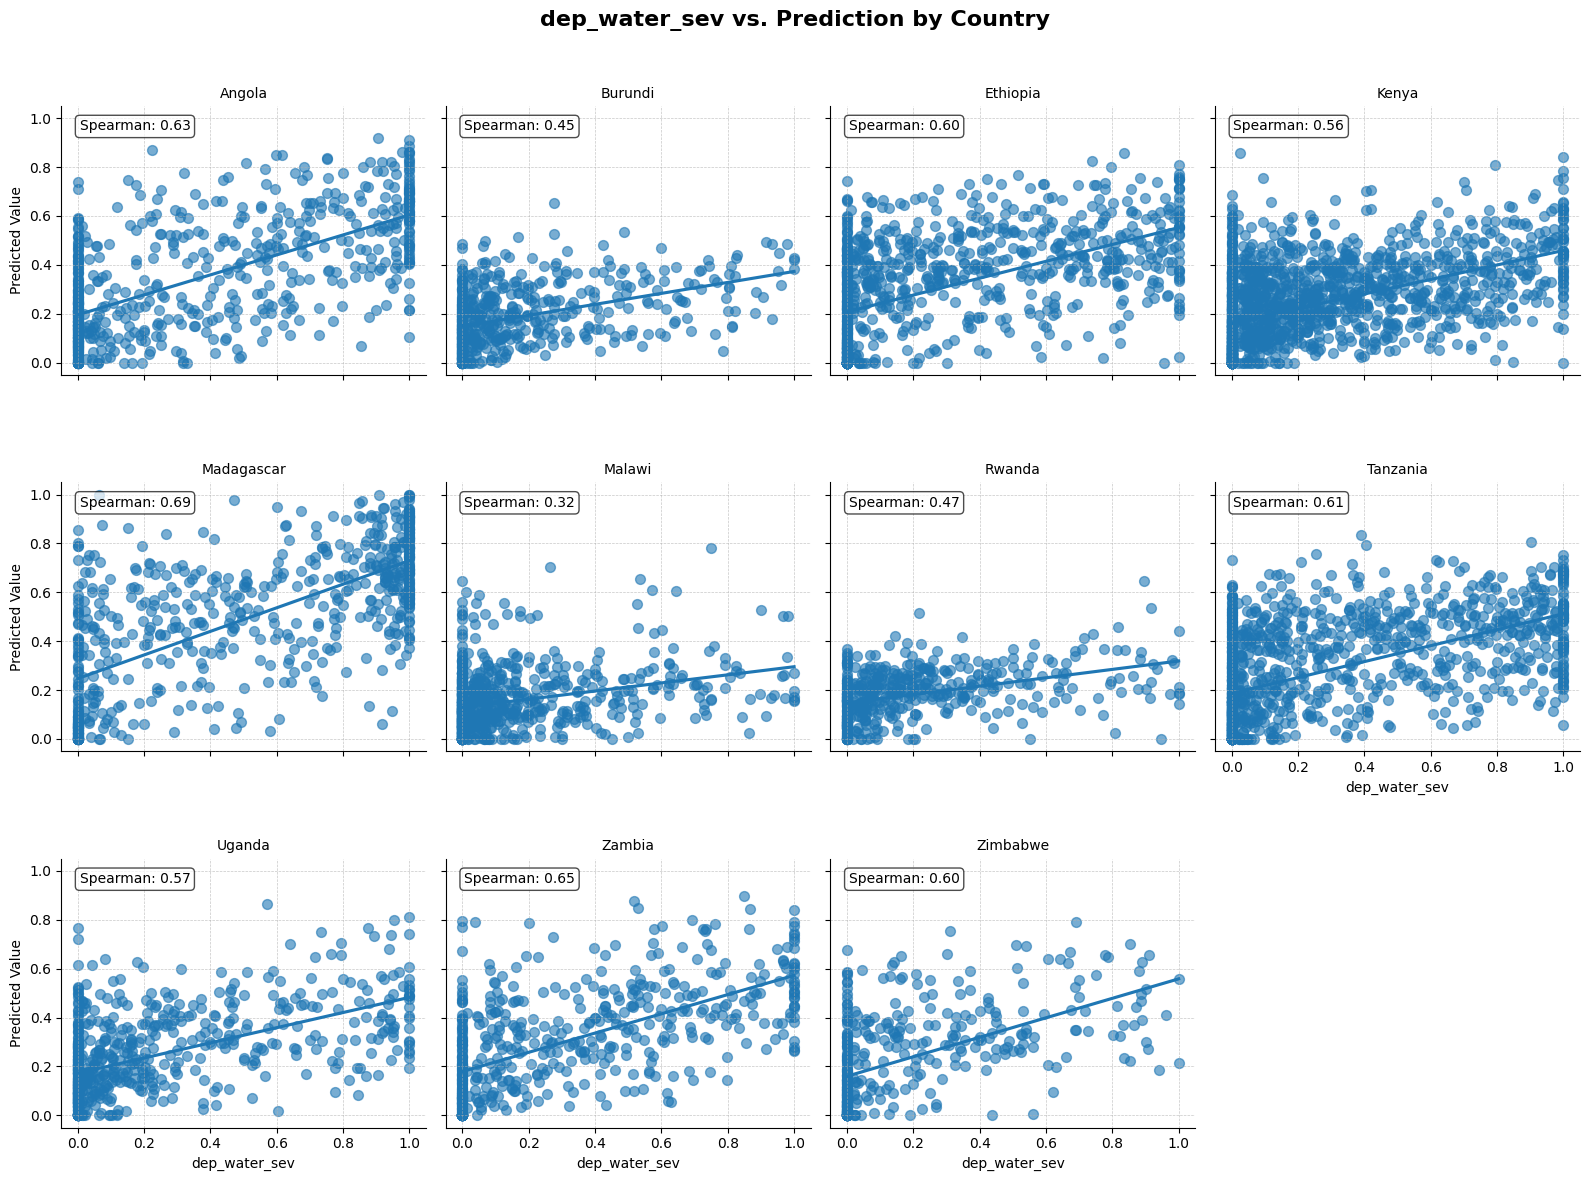

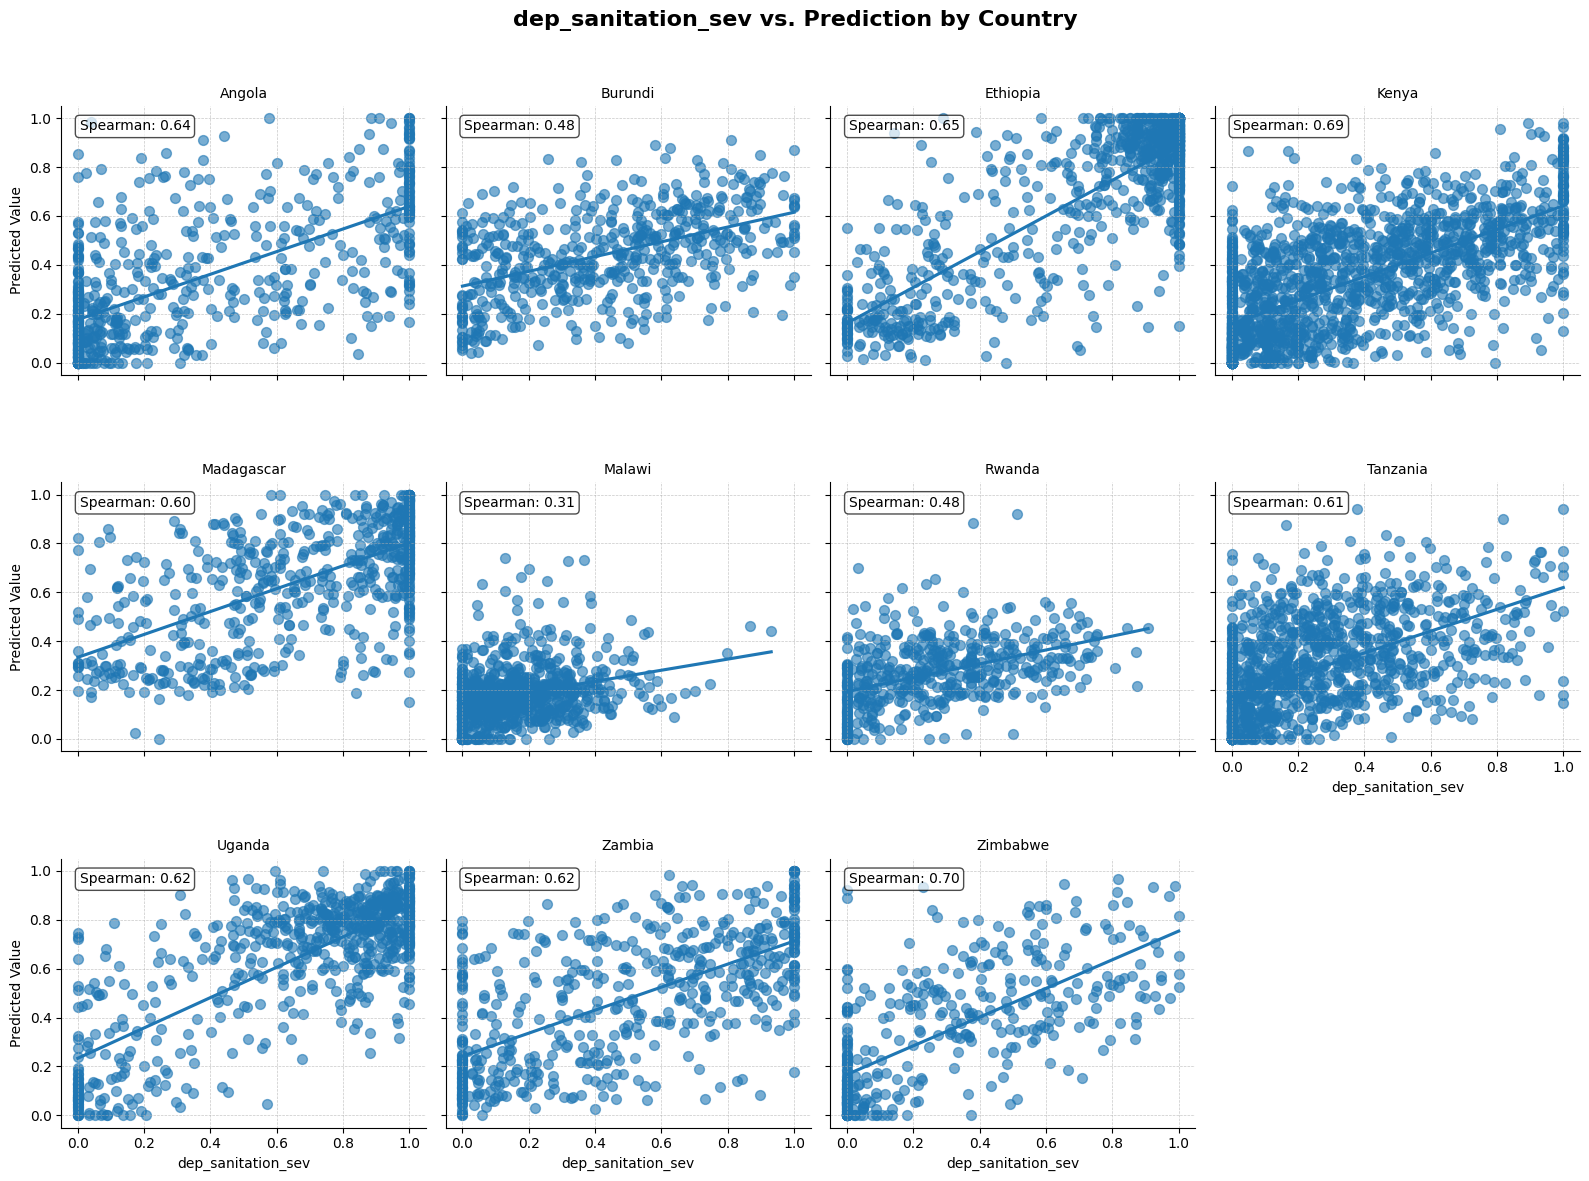

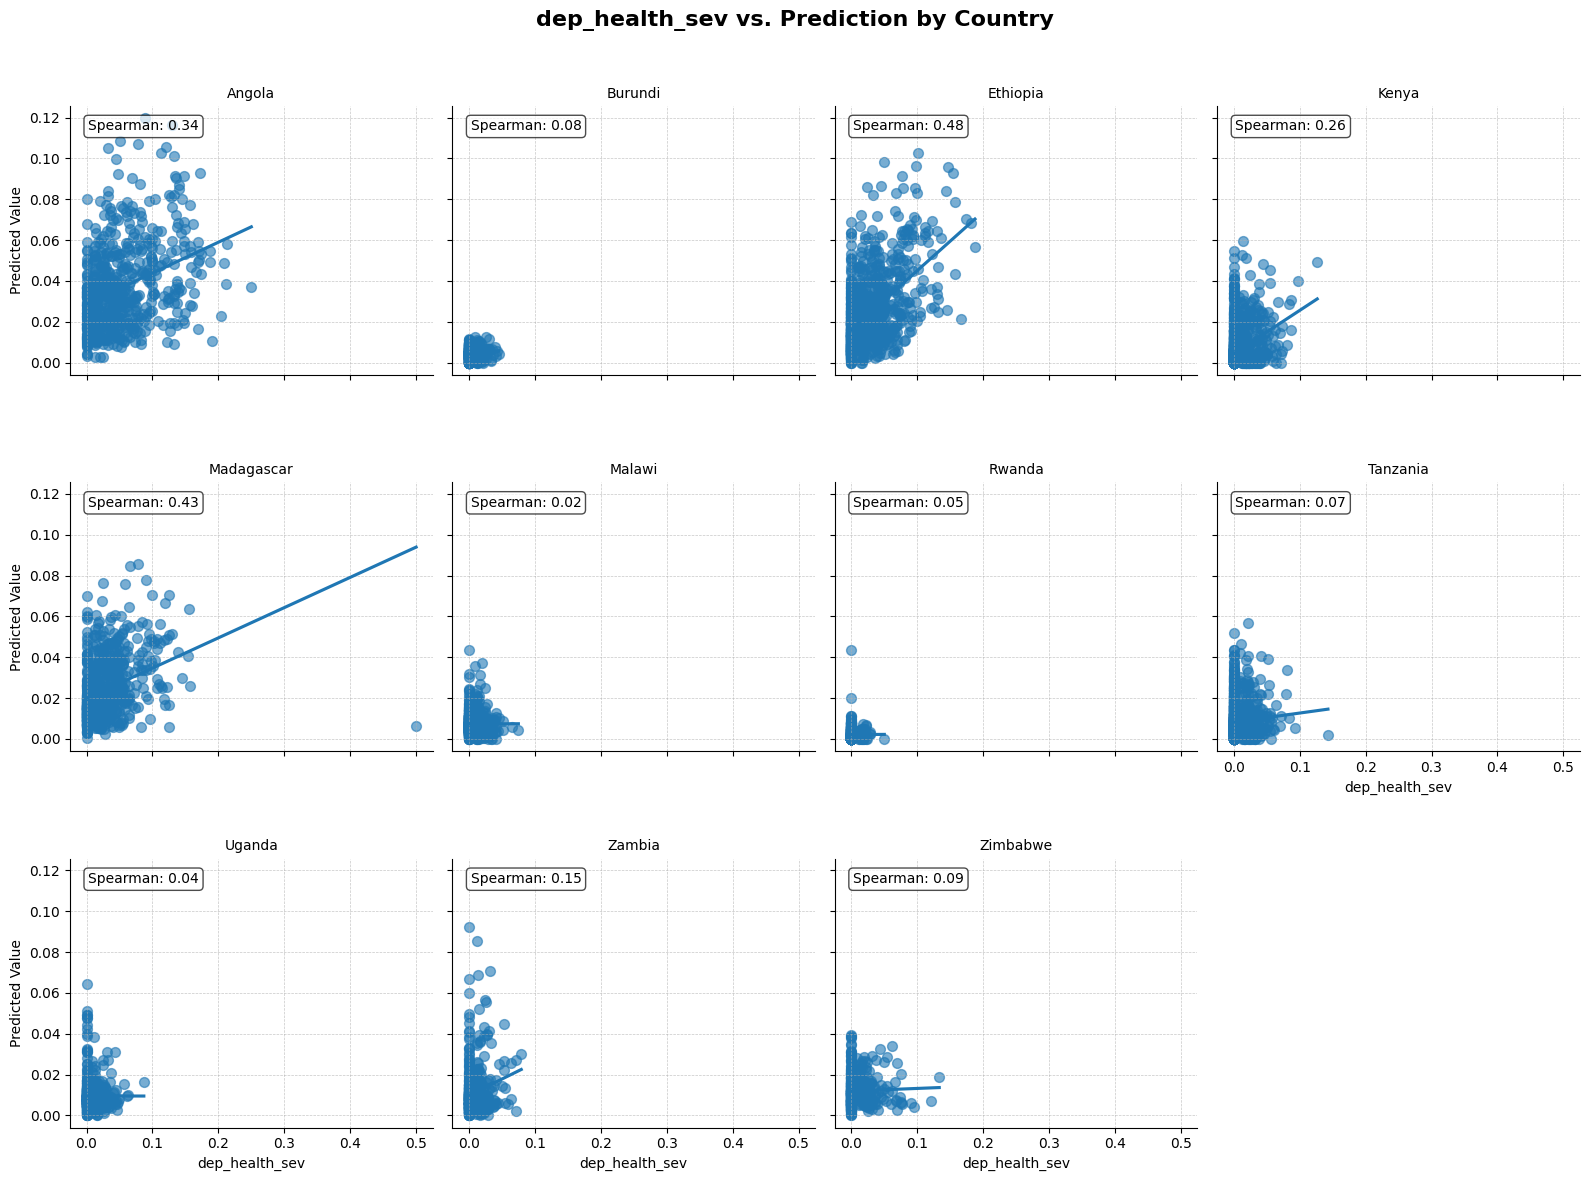

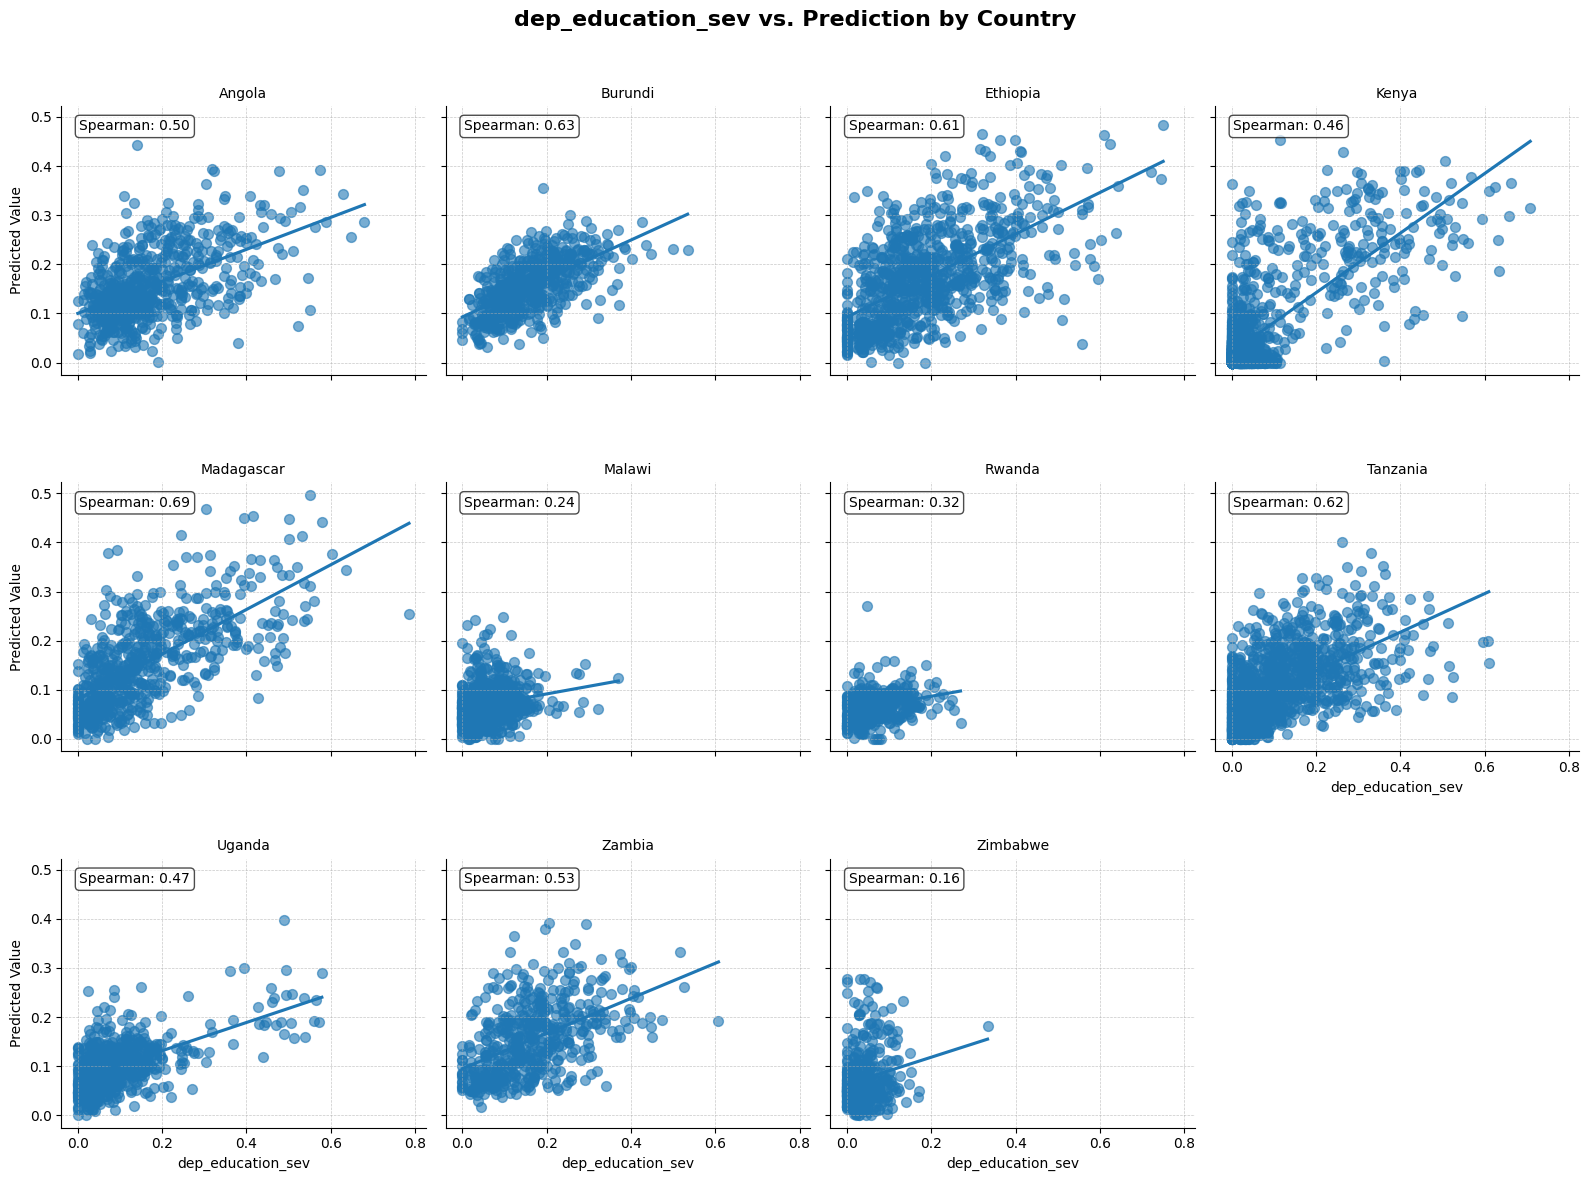

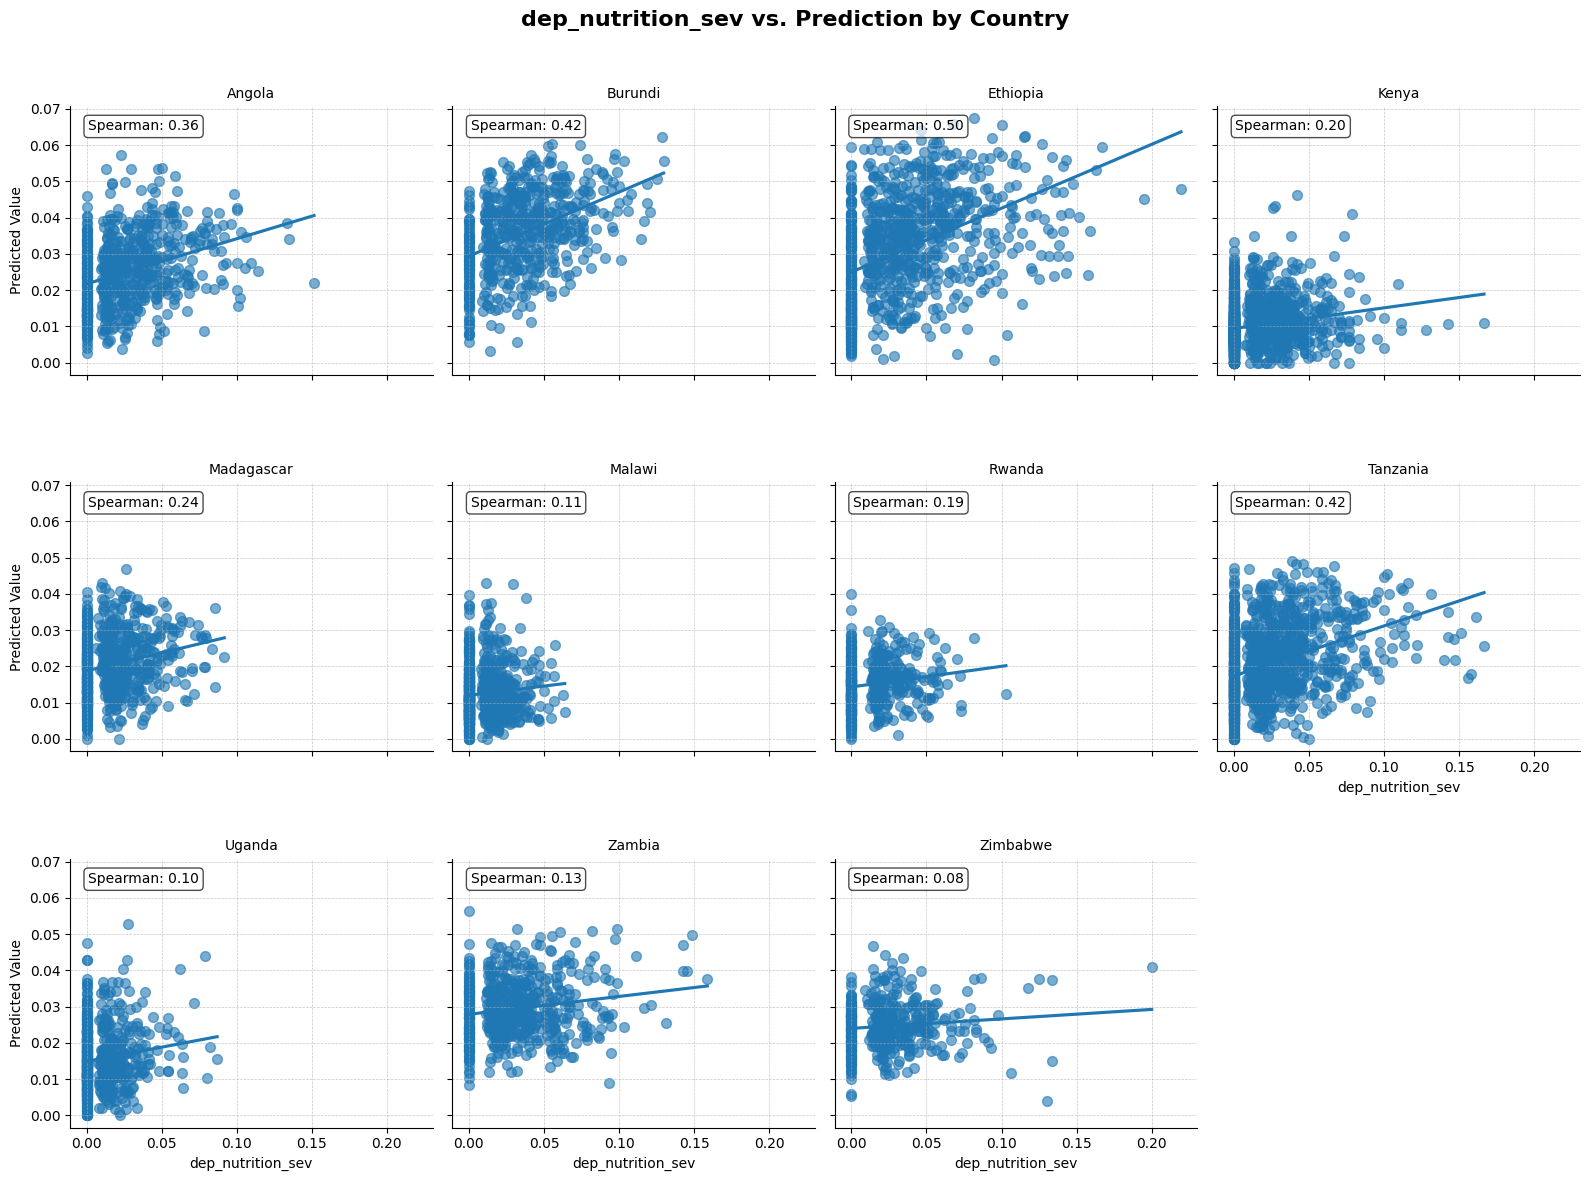

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Create the facet grid scatter plots with regression lines
for ind in sub_indicators:
    g = sns.lmplot(
        data=grouped_df,
        x=ind, 
        y=ind+'_pred', 
        col='COUNTRY', 
        col_wrap=4, 
        height=4, 
        aspect=1, 
        scatter_kws={'alpha': 0.6, 's': 50},  # Increase marker size for better visibility
        ci=None,
        palette="Set2"  # Use a visually appealing palette
    )
    g.set_titles("{col_name}")  # This sets the title template to just the column name (country)
    # Compute and annotate Spearman R for each subplot
    for ax, country in zip(g.axes.flat, grouped_df['COUNTRY'].unique()):
        country_data = grouped_df[grouped_df['COUNTRY'] == country]
        rho, p_value = spearmanr(country_data[ind], country_data[ind+'_pred'])
        ax.text(
            0.05, 0.95, 
            f'Spearman: {rho:.2f}', 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)  # Add a background box for clarity
        )

    # Improve layout and add a global title
    plt.subplots_adjust(top=0.9, hspace=0.4)  # Adjust subplot spacing
    g.fig.suptitle(ind+" vs. Prediction by Country", fontsize=16, fontweight='bold')

    # Customize axis labels
    g.set_axis_labels(ind, "Predicted Value")

    # Add grid lines for clarity
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.show()

In [13]:
points_gdf = gpd.GeoDataFrame(
    grouped_df,
    geometry=gpd.points_from_xy(grouped_df['LONGNUM'], grouped_df['LATNUM']),
    crs="EPSG:4326"
)
admin2_gdf  = gpd.read_file('afr_adm2/afr_g2014_2013_2.shp')
# 3. Spatial join to find which admin 2 each point belongs to
joined_gdf = gpd.sjoin(points_gdf, admin2_gdf, how="left", predicate="within")

# Assume admin 2 name column in the shapefile is 'ADM2_NAME'
# Now joined_gdf contains 'ADM2_NAME' for each point along with 'value'.

# 4. Aggregate values by admin 2 region if multiple points belong to the same region
joined_gdf['ADM2_NAME'] = joined_gdf['ADM2_NAME_left']

# Merge aggregated data back into the admin2_gdf
choropleth_gdf = admin2_gdf.merge(joined_gdf, on='ADM2_CODE', how='right')
# choropleth_gdf = joined_gdf


KeyboardInterrupt: 

In [ ]:
# remove nan from choropleth_gdf
choropleth_gdf = choropleth_gdf.dropna(subset=['are'])
# remove inf from choropleth_gdf
choropleth_gdf = choropleth_gdf[~choropleth_gdf['are'].isin([float('inf')])]

<Axes: >

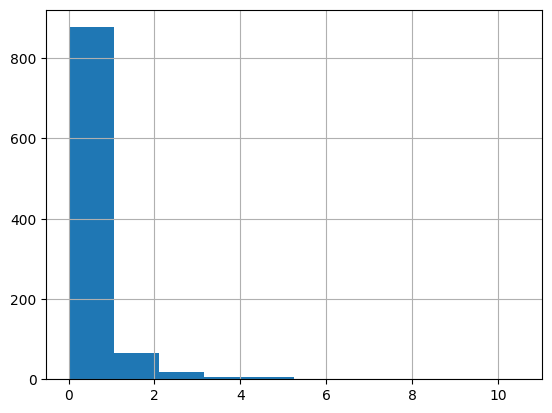

In [ ]:
choropleth_gdf.are.hist()

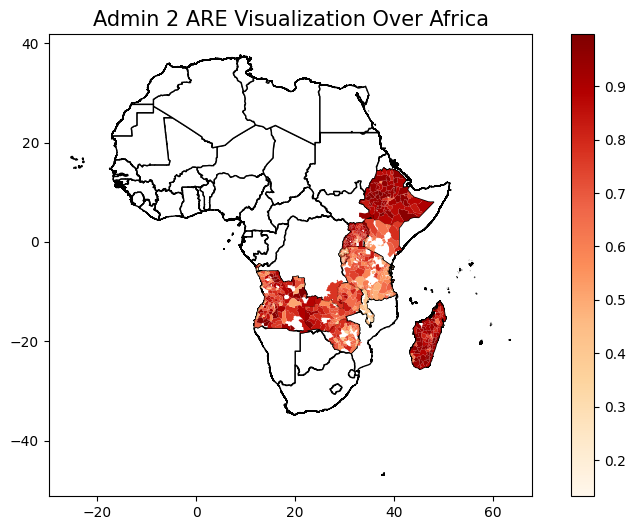

In [ ]:
choropleth_gdf = gpd.GeoDataFrame(choropleth_gdf, geometry='geometry_x')


# Optionally set a title
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Africa boundary shapefile (this could be a countries-level shapefile)
africa_gdf = gpd.read_file('afr_adm0/afr_g2014_2013_0.shp')

# Ensure all GeoDataFrames are in the same CRS
if africa_gdf.crs != choropleth_gdf.crs:
    africa_gdf = africa_gdf.to_crs(choropleth_gdf.crs)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Africa boundary as a base layer
africa_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plot the admin 2 level choropleth on top # adjust line width
choropleth_gdf.plot(column='y_pred', cmap='OrRd', legend=True, ax=ax, linewidth=0.5)

ax.set_title("Admin 2 ARE Visualization Over Africa", fontsize=15)
plt.show()

In [ ]:
choropleth_gdf.REGION_x.unique()

array(['Middle Africa', 'Southern Africa', 'Eastern Africa', None, nan],
      dtype=object)